# Binary classification grade 3 vs grade 4 & 5

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
data_all = pickle.load(open('DATA/processed_data.pkl', 'rb'))
len(data_all)

5182

In [3]:
grades = [d[1] for d in data_all]
pd.DataFrame(grades).value_counts()

0
3    2567
4    2351
5     264
Name: count, dtype: int64

The dataset is well balanced. We have the grade==5 is only 5% of whole data. 

In [4]:
grades_df = pd.read_csv('DATA/rois-with-grade.csv')
grades_df['pickle_grade'] = grades

In [5]:
# grades written in pickle are the as grades in the rois-with-grade.csv
# below I will use the one from pickle
(grades_df['grade'] == grades_df['pickle_grade']).all()

True

Text(0.5, 1.0, 'eosin')

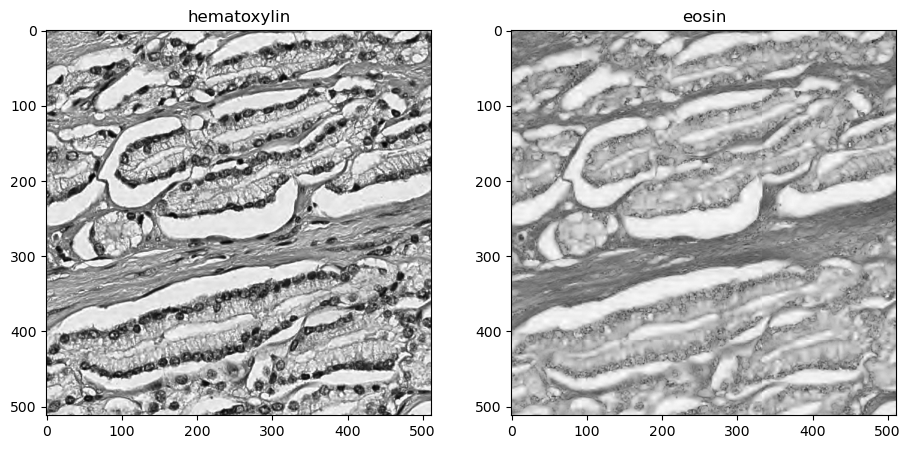

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(11,5))

axs[0].imshow(data_all[0][0][:, :, 0], cmap='gray')
axs[0].set_title('hematoxylin')
axs[1].imshow(data_all[0][0][:, :, 1], cmap='gray')
axs[1].set_title('eosin')

In [7]:
from torchvision import models
import torch.nn as nn
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]
batch_size = 64

transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256, antialias=True),
    transforms.Normalize(IMG_MEAN, IMG_STD),
]
)

In [10]:
class GlysomaDataset(Dataset):
    def __init__(self, data, channel='hema', transform=None):
        assert channel in ['hema', 'eos']
        self.data = data
        self.transform = transform
        self.channel = channel
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        if self.channel == 'hema':
            img = self.data[idx][0][:, :, 0]
        elif self.channel == 'eos':
            img = self.data[idx][0][:, :, 1]
        # pretrained networks accept color images only
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
        grade_is_3 = self.data[idx][1]==3
        if self.transform:
            img = self.transform(img)
        return img, float(grade_is_3)

In [11]:
len(data_all)

5182

In [12]:
# take subset of the data
dataset_ratio = 1.0 # 1.0 == use whole dataset, 0.5 == use only half of the dataset (selected randomly)
if dataset_ratio == 1.0:
    data = data_all
else:
    data, _ = train_test_split(data_all, test_size=1-dataset_ratio, random_state=100)

data_trainval, data_test = train_test_split(data, test_size=0.15, random_state=100)
data_train, data_val = train_test_split(data_trainval, test_size=0.15, random_state=100)

datasets = {
    "train":  GlysomaDataset(data = data_train, channel='hema', transform=transformation),
    "val": GlysomaDataset(data = data_val, channel='hema', transform=transformation),
    "test": GlysomaDataset(data = data_test, channel='hema', transform=transformation)
}
dataloaders = {
    "train": DataLoader(datasets["train"], batch_size=batch_size, shuffle=True, num_workers=0),
    "val": DataLoader(datasets["val"], batch_size=batch_size, shuffle=False, num_workers=0),
    "test": DataLoader(datasets["test"], batch_size=batch_size, shuffle=False, num_workers=0)
}
print('#Train', len(datasets['train']), ' #Val', len(datasets['val']), ' #Test', len(datasets['test']))

#Train 3743  #Val 661  #Test 778


In [13]:
criterion = nn.BCEWithLogitsLoss()
def get_model(backbone: str):
    if backbone == "resnet18":
        model = models.resnet18(weights="IMAGENET1K_V1")
    elif backbone == "resnet34":
        model = models.resnet34(weights="IMAGENET1K_V1")
    elif backbone == "resnet50":
        model = models.resnet50(weights="IMAGENET1K_V1")
    elif backbone == "resnet101":
        model = models.resnet101(weights="IMAGENET1K_V1")
    else:
        raise ValueError(f"backbone={backbone} not supported")
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 1)
    return model

In [14]:
model = get_model(backbone='resnet50')
model.to(device)

lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.9)

# If you set max_epochs = 0 and rerun this and next cells you will see that accuracy on test set is ~0.5 as expected. In this scenerio model is not trained and evaluation is made based on model pretrainedo on ImageNet
max_epochs = 10

metrics_history = {"train": [], "val": []}
for epoch in range(max_epochs):
    print("-" * 10)
    print("Epoch {}/{}".format(epoch, max_epochs - 1))

    for phase in ["train", "val"]:
        if phase == "train":
            for param_group in optimizer.param_groups:
                print("LR", param_group["lr"])
            model.train()  # Set model to training mode
        else:
            model.eval()  # Set model to evaluate mode

        epoch_samples = 0

        running_loss = 0.0
        running_preds = []
        running_labels = []

        # Iterate over data.
        for inputs, labels in tqdm(dataloaders[phase], desc=f"Ep: {epoch} {phase}"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels = torch.unsqueeze(labels, 1)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == "train"):
                outputs = model(inputs)
                preds = torch.sigmoid(outputs) > 0.5
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == "train":
                    loss.backward()
                    optimizer.step()

            # statistics
            epoch_samples += inputs.size(0)
            running_loss += loss.item() * inputs.size(0)
            running_preds.append(preds)
            running_labels.append(labels.data)

        if phase == "train":
            scheduler.step()

        epoch_loss = running_loss / epoch_samples
        
        preds = torch.cat(running_preds).cpu()
        labels = torch.cat(running_labels).cpu()
        epoch_acc = accuracy_score(labels, preds)
        epoch_bac = balanced_accuracy_score(labels, preds)
        
        metrics_history[phase].append({"loss": epoch_loss, "acc": epoch_acc, "bac": epoch_bac})
        
    

----------
Epoch 0/9
LR 0.0001


Ep: 0 val: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.42it/s]


----------
Epoch 1/9
LR 0.0001


Ep: 1 val: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.19it/s]


----------
Epoch 2/9
LR 0.0001


Ep: 2 val: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.33it/s]


----------
Epoch 3/9
LR 0.0001


Ep: 3 val: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.09it/s]


----------
Epoch 4/9
LR 0.0001


Ep: 4 val: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.39it/s]


----------
Epoch 5/9
LR 0.0001


Ep: 5 val: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.34it/s]


----------
Epoch 6/9
LR 0.0001


Ep: 6 val: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.16it/s]


----------
Epoch 7/9
LR 9e-05


Ep: 7 val: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.06it/s]


----------
Epoch 8/9
LR 9e-05


Ep: 8 val: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.06it/s]


----------
Epoch 9/9
LR 9e-05


Ep: 9 val: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.22it/s]


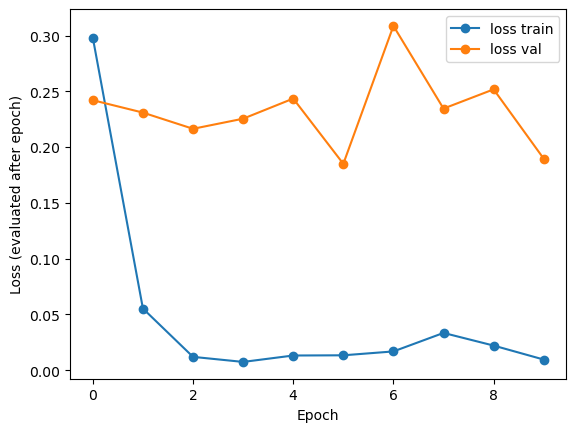

Text(0.5, 0, 'Epoch')

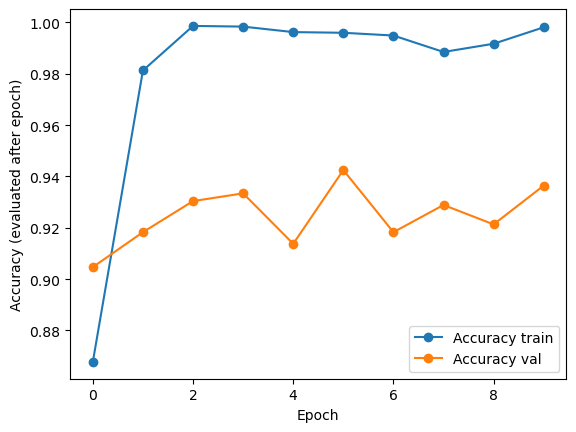

In [15]:
# make simple plot
for phase in ['train', 'val']:
    _losses = [x['loss'] for x in metrics_history[phase]]
    plt.plot(_losses, 'o-', label=f'loss {phase}')
plt.legend()
plt.ylabel('Loss (evaluated after epoch)')
plt.xlabel('Epoch')
plt.show()

for phase in ['train', 'val']:
    _losses = [x['acc'] for x in metrics_history[phase]]
    plt.plot(_losses, 'o-', label=f'Accuracy {phase}')
plt.legend()
plt.ylabel('Accuracy (evaluated after epoch)')
plt.xlabel('Epoch')

In [40]:
# Prediction on test set
all_labels = []
all_preds = []
for inputs, labels in tqdm(dataloaders['test'], desc=f"Test"):
    inputs = inputs.to(device)
    all_labels.append(labels > 0.5)
    labels = labels.to(device)
    labels = torch.unsqueeze(labels, 1)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward
    # track history if only in train
    with torch.set_grad_enabled(phase == "train"):
        outputs = model(inputs)
        preds = torch.sigmoid(outputs) > 0.5
        all_preds.append(preds)
        
all_labels = torch.concat(all_labels).cpu()
all_preds = torch.concat(all_preds).cpu()

Test: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.62it/s]


In [41]:
bacc = balanced_accuracy_score(all_labels, all_preds)
acc = accuracy_score(all_labels, all_preds)
bacc, acc

(0.9453530221234254, 0.9460154241645244)

In [43]:
pd.DataFrame(
    {
        'label': all_labels.numpy(), 
        'pred': all_preds.numpy().reshape(-1,)
    }
)

,label,pred
0,True,True
1,False,False
2,True,True
3,True,True
4,True,True
...,...,...
773,False,False
774,True,True
775,True,True
776,False,False
